In [141]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits as mp
import seaborn as sns
import src.make_data as generate
import src.plots as plot
import csv
from sklearn.ensemble import GradientBoostingClassifier
from src.model import Model
import src.pipeline as pipeline
from sklearn.metrics import log_loss

%matplotlib inline
plt.style.use('ggplot')

In [3]:
%load_ext autoreload
%autoreload 2

In [27]:
df = pd.read_csv('data/merged_data.csv')


In [29]:
df.drop_duplicates(inplace=True)

In [122]:
df.head()

,fire_year,discovery_date,discovery_doy,discovery_time,stat_cause_code,stat_cause_descr,cont_date,cont_doy,cont_time,fire_size,...,tobs,month_y,year,doy,cause_group,binned_tmax,tmax_binned,fire_size_binned,latitude_x_binned,longitude_x_binned
0,2005,2453540.5,170,1430.0,1.0,Lightning,2453541.5,171.0,1400.0,0.3,...,56.0,6,2005,170,other,"(60, 70]","(60, 70]","(0, 1]","(46.1, 46.4]","(-118.2, -117.7]"
1,2005,2453567.5,197,1354.0,4.0,Campfire,2453567.5,197.0,1600.0,0.1,...,50.0,7,2005,197,human,"(60, 70]","(60, 70]","(0, 1]","(45.8, 46.1]","(-118.2, -117.7]"
2,2005,2453516.5,146,950.0,6.0,Railroad,2453516.5,146.0,1020.0,0.1,...,NaN,5,2005,146,other,"(80, 90]","(80, 90]","(0, 1]","(45.5, 45.8]","(-121.7, -121.2]"
3,2005,2453585.5,215,1236.0,9.0,Miscellaneous,2453585.5,215.0,1402.0,0.1,...,83.0,8,2005,215,other,"(80, 90]","(80, 90]","(0, 1]","(48.2, 48.5]","(-117.2, -116.7]"
4,2005,2453555.5,185,2002.0,6.0,Railroad,2453555.5,185.0,2010.0,0.1,...,68.0,7,2005,185,other,"(80, 90]","(80, 90]","(0, 1]","(45.5, 45.8]","(-121.7, -121.2]"


In [124]:
y = df['cause_group'].values

In [127]:
y = y == 'human'

In [128]:
y

array([False,  True, False, ...,  True, False,  True], dtype=bool)

In [32]:
df['date_start'] = pd.to_datetime(df['date_start'])
df['date_end'] = pd.to_datetime(df['date_end'])


In [56]:
df['tmax'].loc[df['tmax'] == 606.0] = 60.6
df['tmax'].loc[df['tmax'] == 512.0] = 51.2

/Users/Maggie/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [57]:
df[df['tmax'] > 150]

,fire_year,discovery_date,discovery_doy,discovery_time,stat_cause_code,stat_cause_descr,cont_date,cont_doy,cont_time,fire_size,...,snow,snwd,tavg,tmax,tmin,tobs,month_y,year,doy,cause_group


### Cause of Fire EDA

In [33]:
def group_cause(cause):
    
    human_activity = ['Debris Burning', 'Campfire', 'Arson', 'Children', 'Fireworks', 'Smoking', 'Equipment Use']
    other = ['Missing/Undefined', 'Powerline', 'Railroad', 'Structure', 'Lightning', 'Miscellaneous']
    #nature = ['Lightning']
    
    if cause in human_activity: 
        return 'human'
    elif cause in other:
        return 'other'
    

In [34]:
df['cause_group'] = np.vectorize(group_cause)(df['stat_cause_descr'])

In [35]:
cause_groupby = df.groupby('stat_cause_descr')
cause_group_grouby = df.groupby('cause_group')

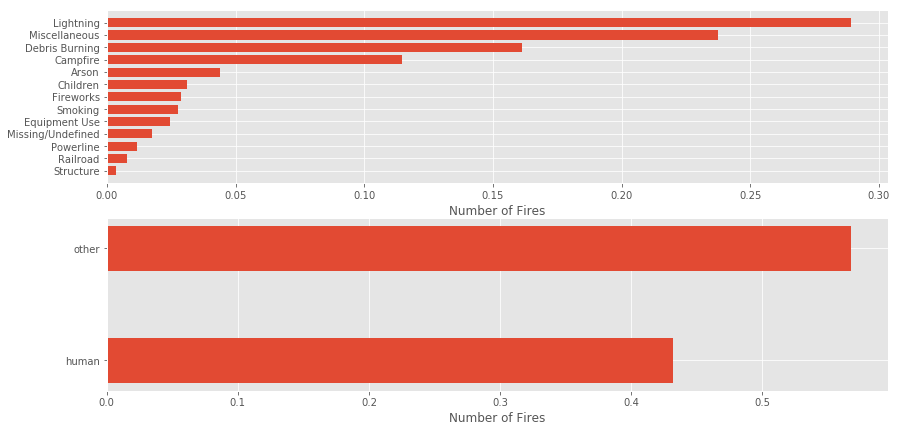

In [36]:
fig, axs = plt.subplots(2,1, figsize=(14,7))

cause_counts = cause_groupby.count().sort_values('fire_year', ascending=True)
total_fires = cause_counts.iloc[:,1].values.sum()
axs[0].barh(np.linspace(0,13,13), cause_counts['stat_cause_code']/total_fires, tick_label=cause_counts.index)
axs[0].set_xlabel('Number of Fires')

cause_group_counts = cause_group_grouby.count().sort_values('fire_year', ascending=True)
axs[1].barh(np.linspace(0,2,2), cause_group_counts['stat_cause_code']/total_fires, tick_label=cause_group_counts.index)
axs[1].set_xlabel('Number of Fires')


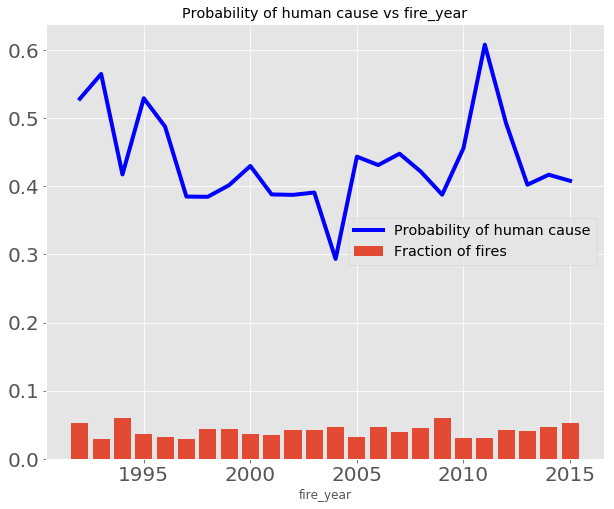

In [83]:
fig, ax = plt.subplots(figsize=(10,8))
plot.univariate_plot('fire_year', ax, df)

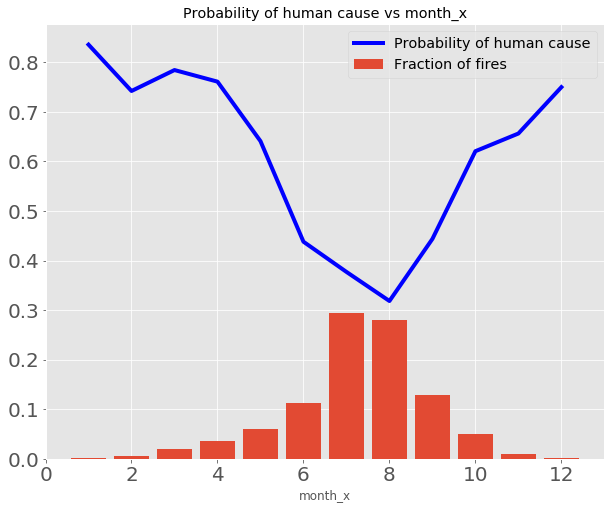

In [84]:
fig, ax = plt.subplots(figsize=(10,8))
plot.univariate_plot('month_x', ax, df)
    

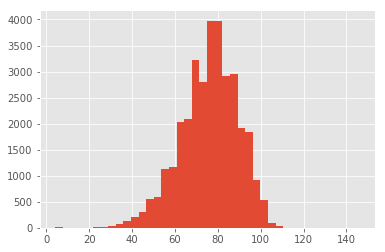

In [60]:
df['tmax'].hist(bins=40)

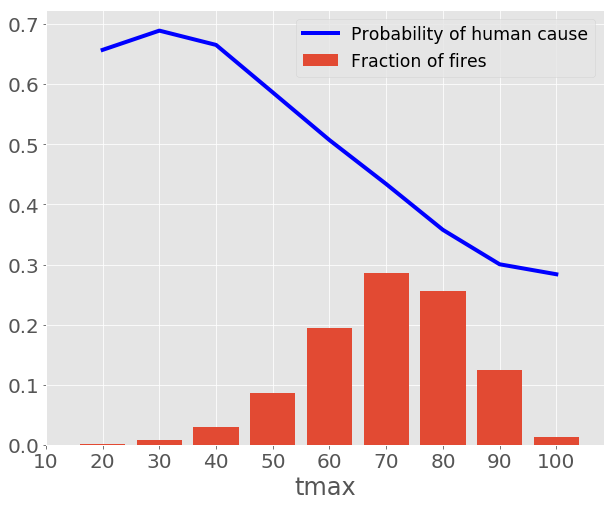

In [85]:
fig, ax = plt.subplots(figsize=(10,8))

tmax_bins = np.arange(10,120,10)
_ = plot.univariate_binned_plot(tmax_bins,'tmax', ax, df)


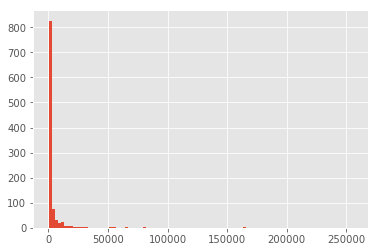

In [94]:
df['fire_size'][df['fire_size'] > 100].hist(bins=100)

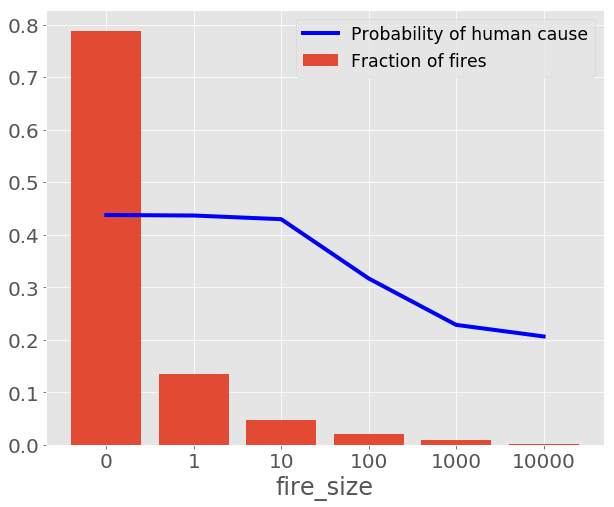

In [96]:
fig, ax = plt.subplots(figsize=(10,8))

fire_size_bins = np.array([0,1,10,100,1000,10000,30000])
_ = plot.univariate_binned_plot(fire_size_bins,'fire_size', ax, df)


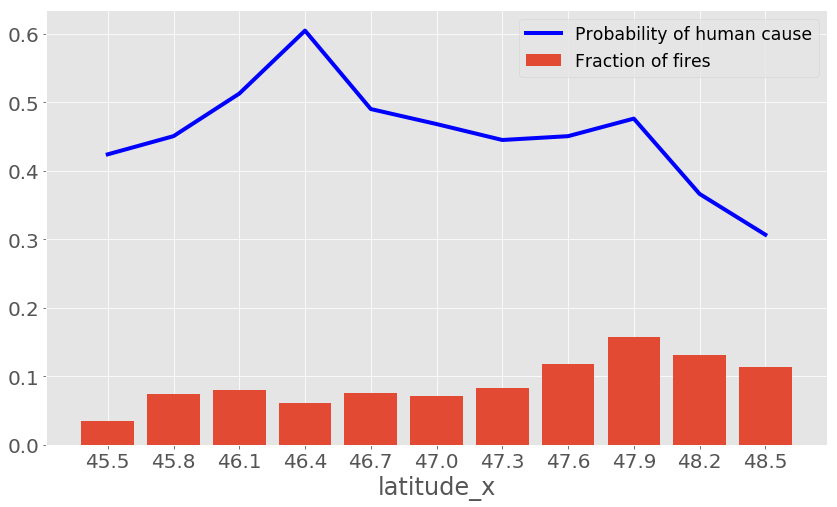

In [111]:
fig, ax = plt.subplots(figsize=(14,8))

lat_bins = np.arange(45.5,49, 0.3)
_ = plot.univariate_binned_plot(lat_bins,'latitude_x', ax, df)


In [114]:
df['longitude_x'].max()

-116.0

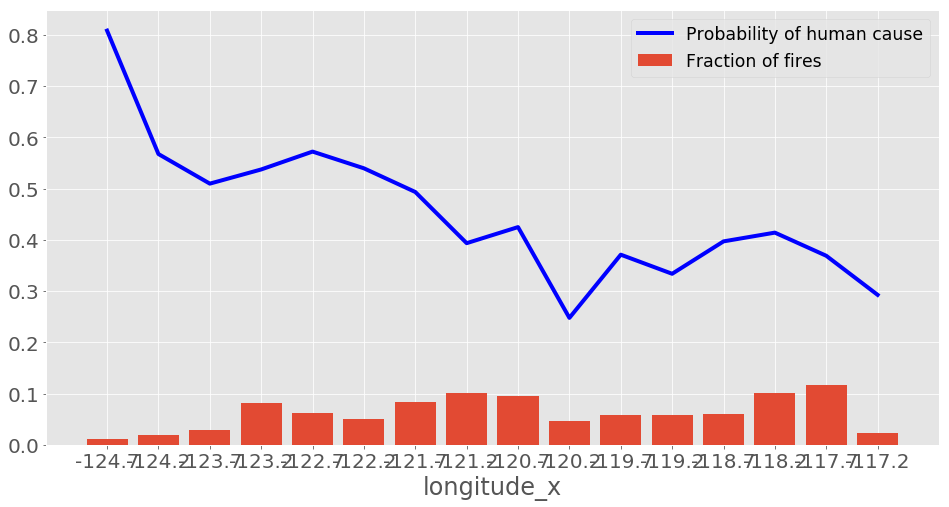

In [119]:
fig, ax = plt.subplots(figsize=(16,8))

long_bins = np.arange(-124.7,-116.5, 0.5)
_ = plot.univariate_binned_plot(long_bins,'longitude_x', ax, df)


TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

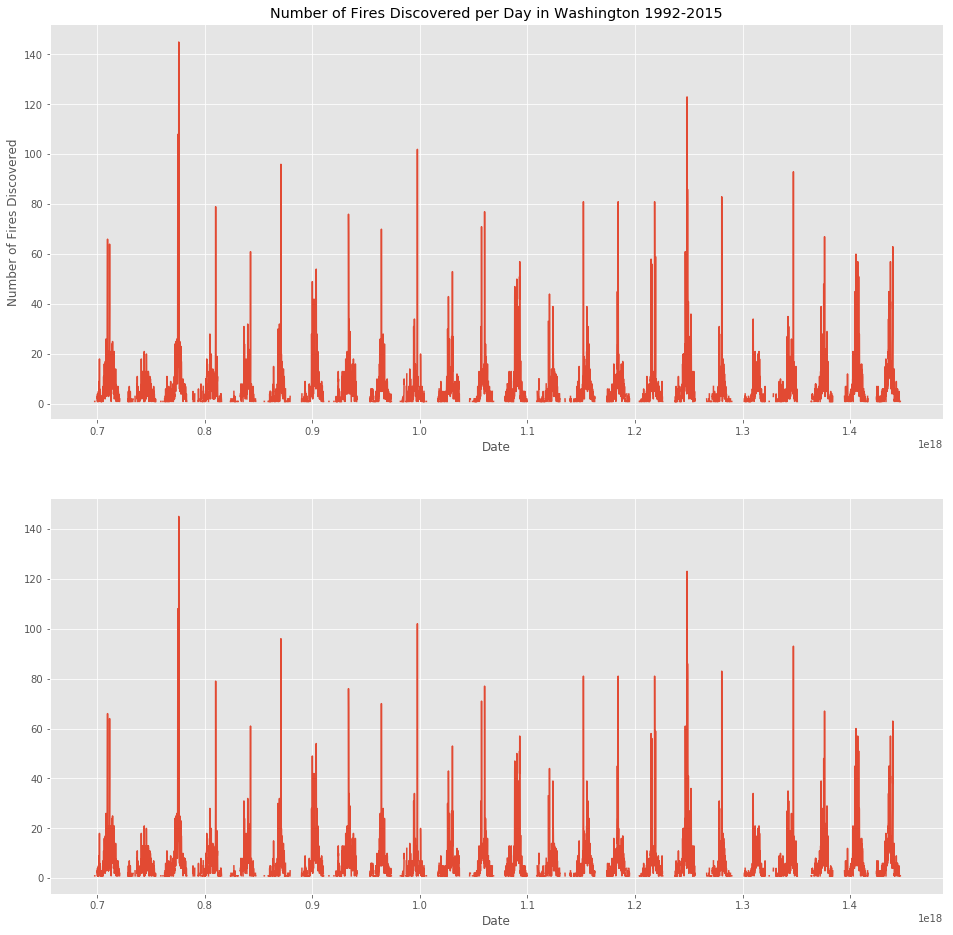

In [13]:
# Time series plots
index = pd.date_range(df["date_start"].min(), df["date_start"].max())
groupby_date = df.groupby("date_start")
count_timeseries = pd.Series(data = groupby_date['fire_year'].count(), index=index)

fig, axs = plt.subplots(2,1,figsize=(16,16))

axs[0].plot(count_timeseries.index, count_timeseries.values)
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Number of Fires Discovered')
axs[0].set_title('Number of Fires Discovered per Day in Washington 1992-2015')

axs[1].plot(count_timeseries.index, count_timeseries.values)
axs[1].set_xlabel('Date')
axs[1].set_xlim((pd.Timestamp('2010-01-01 00:00:00'), pd.Timestamp('2015-11-27 00:00:00')))
#axs[1].set_xlim('2010-01-01 00:00:00', '2015-11-27 00:00:00')
axs[1].set_ylim(-5,50)
axs[1].set_ylabel('Number of Fires Discovered')
axs[1].set_title('Number of Fires Discovered per Day in Washington 2010-2015')


In [ ]:
year_count = df.groupby('fire_year').count()['state']

fig, ax = plt.subplots(figsize=(10,6))

ax.bar(year_count.index, year_count.values)
ax.set_xlabel('Year')
ax.set_ylabel('Number of fires')
ax.set_title("Number of fire per year in Washington 1992-2015")

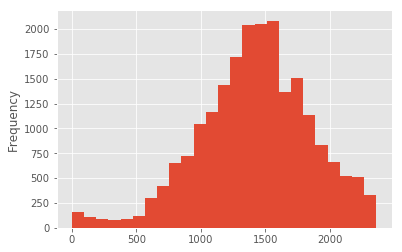

In [134]:
df['discovery_time'].plot(kind='hist', bins=25)

In [ ]:
# Do I want this?
#keep_cols = ['fire_year', 'date_start', 'month', 'discovery_doy',
#                'latitude', 'longitude']
#df = df.loc[:,keep_cols]

## Weather data

In [ ]:
weather = pd.read_csv('data/all_weather')

In [ ]:
weather_keep = ['STATION', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'DATE', 'PRCP',
                    'SNOW', 'SNWD', 'TAVG', 'TMAX', 'TMIN', 'TOBS'] # thunder 'WV03' 'WT03'
weather = weather[weather_keep]

In [ ]:
columns = weather.columns
columns = columns.str.lower()
weather.columns = columns

In [ ]:
weather['date'] = pd.to_datetime(weather['date'])
weather['month'] = weather['date'].map(lambda x : x.month)
weather['year'] = weather['date'].map(lambda x : x.year)
weather['doy'] = weather['date'].map(lambda x : x.dayofyear)

In [ ]:
weather_sorted = weather.sort_values(['year', 'doy', 'longitude', 'latitude'])

In [ ]:
weather_sorted['snow'].fillna(value=0.0, inplace=True)
weather_sorted['snwd'].fillna(value=0.0, inplace=True)
weather_sorted['tmax'].fillna(method='ffill', inplace=True)
weather_sorted['tmin'].fillna(method='ffill', inplace=True)

### Map weather to fire data

In [ ]:
group_station = weather_sorted.groupby('station')
station_coordinates = group_station[['latitude', 'longitude']].max()

In [ ]:
def get_nearby_station(lat, long, stations=station_coordinates):
    min_d = 1000
    station = stations.index[0]
    for i in range(len(stations)):
        distance = np.sqrt((lat-stations.iloc[i,0])**2 + (long-stations.iloc[i,1])**2)
        if distance < min_d:
            min_d = distance
            station = stations.index[i]
    return station

In [ ]:
df_eda = df.loc[df['fire_year'] > 2013]

In [ ]:
df_eda['weather_station'] = np.vectorize(get_nearby_station)(df_eda['latitude'], df_eda['longitude'])

In [ ]:
def get_weather(doy, year, station, weather=weather_sorted):
    return weather['tmax'].loc[(weather['station'] == station) &
                                (weather['year'] == year) &
                               (weather['doy'] == doy)]

In [ ]:
df_eda = pd.merge(df_eda, weather_sorted, how='left', left_on=['weather_station', 'fire_year', 'discovery_doy'],
                  right_on=['station', 'year', 'doy'])

In [ ]:
df_eda.head()

In [ ]:
weather_sorted['tmax'].loc[(weather_sorted['station'] == 'USR0000WFTA') &
                                (weather_sorted['year'] == 2014)
                              & (weather_sorted['doy'] == 1)].values

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
univariate_plot('tmax_fire_day', ax, df=df_eda)

### Saprk

In [139]:
import pyspark as ps


In [140]:
spark = (ps.sql.SparkSession.builder 
            .master("local[4]") 
            .appName("weather") 
            .getOrCreate())

In [145]:
df_weather = spark.read.csv('data/all_weather.csv',
                         header=True,
                         quote='"',
                         sep=",",           
                         inferSchema=True)

In [146]:
df_weather.printSchema()

root
 |-- STATION: string (nullable = true)
 |-- NAME: string (nullable = true)
 |-- LATITUDE: string (nullable = true)
 |-- LONGITUDE: string (nullable = true)
 |-- ELEVATION: string (nullable = true)
 |-- DATE: string (nullable = true)
 |-- ACMH: string (nullable = true)
 |-- ACMH_ATTRIBUTES: string (nullable = true)
 |-- ACSH: string (nullable = true)
 |-- ACSH_ATTRIBUTES: string (nullable = true)
 |-- AWND: string (nullable = true)
 |-- AWND_ATTRIBUTES: string (nullable = true)
 |-- DAEV: string (nullable = true)
 |-- DAEV_ATTRIBUTES: string (nullable = true)
 |-- DAPR: string (nullable = true)
 |-- DAPR_ATTRIBUTES: string (nullable = true)
 |-- DASF: string (nullable = true)
 |-- DASF_ATTRIBUTES: string (nullable = true)
 |-- DAWM: string (nullable = true)
 |-- DAWM_ATTRIBUTES: string (nullable = true)
 |-- EVAP: string (nullable = true)
 |-- EVAP_ATTRIBUTES: string (nullable = true)
 |-- FMTM: string (nullable = true)
 |-- FMTM_ATTRIBUTES: string (nullable = true)
 |-- MDEV: stri

In [ ]:
group_station_month = df_weather_2014.groupby(['STATION', 'MONTH'])
monthly_precip = group_station_month['PRCP'].sum()
monthly_snow = group_station_month['SNOW'].sum()
monthly_tmax = group_station_month['TMAX'].mean()
monthly_tmin = group_station_month['TMIN'].mean()
monthly_tobs = group_station_month['TOBS'].mean()
 

In [ ]:
group_station = df_weather_2014.groupby('STATION')
station_coordinates = group_station[['LATITUDE', 'LONGITUDE']].max()

In [ ]:
df_monthly_weather = pd.concat([monthly_precip, monthly_snow, monthly_tmax, monthly_tmin, monthly_tobs], axis=1)

In [ ]:
#df_monthly_weather.reset_index(level=0, inplace=True)
df_monthly_weather.reset_index(level=1, inplace=True)
df_monthly_weather.head()

In [ ]:
station_coordinates.plot(x='LONGITUDE', y='LATITUDE', kind='scatter', alpha=.6, figsize=(10,8), title='Location of weather stations')


In [ ]:

sns.lmplot( x='LONGITUDE', y='LATITUDE', data=df_fires_2014, fit_reg=False, hue='FIRE_SIZE_CLASS', 
            size=10, legend=True)


In [ ]:
df_fires_2014.groupby('FIRE_SIZE_CLASS')['DATE'].count().plot(kind='bar')

In [ ]:
df_fires_2014.groupby('FIRE_SIZE_CLASS')['DATE'].count()

In [ ]:
def get_nearby_station(lat, long, stations=station_coordinates):
    min_d = 1000
    station = stations.index[0]
    for i in range(len(stations)):
        distance = np.sqrt((lat-stations.iloc[i,0])**2 + (long-stations.iloc[i,1])**2)
        if distance < min_d:
            min_d = distance
            station = stations.index[i]
    return station
            
        
        

In [ ]:
def get_weather(month, station, weather=df_monthly_weather):
    month = min(1, month-1)
    return df_monthly_weather['PRCP'].loc[(df_monthly_weather['STATION'] == station) &
                                         (df_monthly_weather['MONTH'] == month)].values

In [ ]:
df_fires_2014['STATION'] = np.vectorize(get_nearby_station)(df_fires_2014['LATITUDE'], df_fires_2014['LONGITUDE'])

In [ ]:
df_fires_2014['PRCP'] = np.vectorize(get_weather)(df_fires_2014['MONTH'], df_fires_2014['STATION'])

In [ ]:
df_monthly_weather['PRCP'].loc[(df_monthly_weather['STATION'] == 'CA001018611') &
                                         (df_monthly_weather['MONTH'] == 10)].values

In [ ]:
len(df_monthly_weather['STATION'].unique())

In [ ]:
min(1,2)

### Spatial grid

In [ ]:
min_lat = df['latitude'].min()
max_lat = df['latitude'].max()
min_long = df['longitude'].min()
max_long = df['longitude'].max()
print(min_lat, max_lat, min_long, max_long)

In [ ]:
lat_steps = 100
long_steps = 300

lat_grid = np.linspace(min_lat, max_lat, lat_steps)
long_grid = np.linspace(min_long, max_long, long_steps)

In [ ]:
np.argsort(lat_grid - 46.7)

In [ ]:
def get_grid(lat, long, lat_grid, long_grid):
    

In [ ]:
lat_grid = np.linspace(max_lat, min_lat, 100)
long_grid = np.linspace(min_long, max_long, 100)

In [ ]:
one_month_weahter = df_monthly_weather[df_monthly_weather['MONTH'] == 6]

In [ ]:
one_month_weahter = pd.concat([one_month_weahter,station_coordinates], axis=1)

In [ ]:
one_month_fires = df_fires_2014[df_fires_2014['MONTH']==7]

In [ ]:
one_month_fires.head()

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))

ax.scatter(one_month_weahter['LONGITUDE'], one_month_weahter['LATITUDE'], c=one_month_weahter['PRCP'], alpha=0.5)
ax.scatter(one_month_fires['LONGITUDE'], one_month_fires['LATITUDE'], alpha=0.6)
#ax.legend()


In [ ]:
len(one_month_weahter['PRCP'])

In [ ]:
one_month_weahter.loc['CA001018611','TMAX']

In [ ]:
prcp_map = np.zeros([100,100])

In [ ]:
prcp_map.shape

In [ ]:
def get_coord_weather(lat, long, measurement='PRCP', df=one_month_weahter):
    station = get_nearby_station(lat, long)
    return df.loc[station, measurement]
    
    

In [ ]:
np.where(prcp_map)

In [ ]:
map_df = pd.DataFrame(prcp_map, index=lat_grid, columns=long_grid)

In [ ]:
map_df.head()

In [ ]:
for i, long in enumerate(long_grid):
    if i%10==0: print (i)
    map_df.iloc[:,i] = np.vectorize(get_coord_weather)(lat_grid, np.array([long]*len(long_grid)))

In [ ]:
map_df_fill = map_df.fillna(method='ffill')
map_df_fill = map_df_fill.fillna(method='bfill')


In [ ]:
fig, ax = plt.subplots(figsize=(14,8))

lat_grid = np.linspace(max_lat, min_lat, 100)
long_grid = np.linspace(min_long, max_long, 100)
long_conversion = (one_month_fires['LONGITUDE']-min_long) * 100/(max_long-min_long)
lat_conversion = (one_month_fires['LATITUDE']-max_lat) * 100/(min_lat-max_lat)

my_cmap = sns.light_palette("Blue", as_cmap=True)

#ax.set_ylim(min_lat, max_lat)
#ax.set_xlim(min_long, max_long)
#ax.imshow(map_df_fill.values, cmap='hot', norm=True)
sns.heatmap(map_df_fill, alpha=1, cmap=my_cmap, center=1, ax=ax, label='Total precipitation')
ax.scatter(long_conversion, lat_conversion,  c='r', alpha=0.6, label='Wildfires')
ax.legend()
ax.set_title('Location of Wildfires and Total Precipitation in the Previous Month')



In [ ]:
# weather heatmap with fire locations 
def weather_heatmap(month, measurement, lat_grid=lat_grid, long_grid=long_grid, df_monthly_weather=df_monthly_weather, 
                    station_coordinates=station_coordinates, df_fires_2014=df_fires_2014):

    one_month_weahter = df_monthly_weather[df_monthly_weather['MONTH'] == month-1]
    one_month_weahter = pd.concat([one_month_weahter,station_coordinates], axis=1)
    one_month_fires = df_fires_2014[df_fires_2014['MONTH']==month]

    prcp_map = np.zeros([100,100])
    map_df = pd.DataFrame(prcp_map, index=lat_grid, columns=long_grid)

    for i, long in enumerate(long_grid):
        if i%10==0: print (i)
        map_df.iloc[:,i] = np.vectorize(get_coord_weather)(lat_grid, np.array([long]*len(long_grid)), measurement)
        
    map_df_fill = map_df.fillna(method='ffill')
    map_df_fill = map_df_fill.fillna(method='bfill')
    
    min_lat = lat_grid[-1]
    max_lat = lat_grid[0]
    min_long = long_grid[0]
    max_long = long_grid[-1]

    fig, ax = plt.subplots(figsize=(14,8))

    long_conversion = (one_month_fires['LONGITUDE']-min_long) * 100/(max_long-min_long)
    lat_conversion = (one_month_fires['LATITUDE']-max_lat) * 100/(min_lat-max_lat)

    my_cmap = sns.light_palette("Blue", as_cmap=True)

    #ax.set_ylim(min_lat, max_lat)
    #ax.set_xlim(min_long, max_long)
    #ax.imshow(map_df_fill.values, cmap='hot', norm=True)
    sns.heatmap(map_df_fill, alpha=1, cmap=my_cmap, center=1, ax=ax, label=measurement)
    ax.scatter(long_conversion, lat_conversion,  c='r', alpha=0.6, label='Wildfires')
    ax.legend()
    ax.set_title('Location of Wildfires in month {} and {} in the Previous Month'.format(month, measurement))

In [ ]:
weather_heatmap(8, 'TMAX')

In [ ]:
weather_heatmap(9, 'PRCP')

### Model test

In [134]:
features = ["fire_year", "discovery_doy", "fire_size", "latitude_x",
                     "longitude_x", "elevation", "prcp", "snow", "tmax", "tmin"]

In [153]:
model = Model('gbc', n_estimators=1000)

In [154]:
X, y = pipeline.get_model_features('data/merged_data.csv', features, 'cause_group', 'human')

In [155]:
model.cross_validate(5, X, y)

fold: 1, log-loss: 0.55
fold: 2, log-loss: 0.55
fold: 3, log-loss: 0.54
fold: 4, log-loss: 0.54
fold: 5, log-loss: 0.55


([0.54527612767189315,
  0.55002431635245119,
  0.54067588397397148,
  0.54322120224171699,
  0.54855120228010301],
 [],
 [],
 [])

In [142]:
mean = y.mean()

In [145]:
mean_pred = np.array([mean]*y.shape[0])

In [148]:
log_loss(y, mean_pred)

0.68389807489019738